In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [330]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from torch.utils.data import Dataset 
import os
from IPython import display
import torch
import torch.nn as nn
from skimage import io
from torchvision import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
%matplotlib inline
import torchvision
from PIL.Image import open, BILINEAR
import os
import random
from PIL import Image
import random

In [331]:
# !wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# !unzip -q data.zip

In [3]:
im = Image.open('./img_scab/Train_0.jpg')

In [4]:
np.shape(io.imread('./img_scab/Train_0.jpg')[:,:,0])

(1365, 2048)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


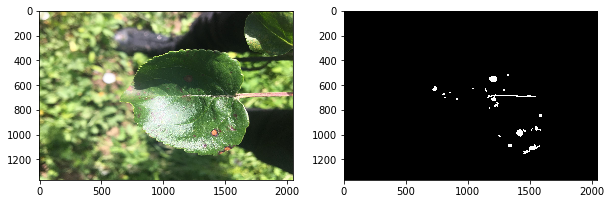

In [5]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('./img_both/Train_1018.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = io.imread('./masks_machine_both/Train_1018.png')*(255/2)
plt.imshow(mask, 'tab20')

In [6]:
im =io.imread('./masks_machine_scab/Train_1003.png')*255

In [7]:
mask =io.imread('./masks_machine_scab/Train_0.png')*(255/2)

In [8]:
np.unique(mask.astype(np.uint8))

array([  0, 255], dtype=uint8)

In [9]:
im  =Image.fromarray(mask.astype(np.uint8))

In [10]:
np.shape(im)

(1365, 2048, 3)

In [11]:
a = transforms.ToTensor()(im)

In [12]:
np.unique(a.numpy())

array([0., 1.], dtype=float32)

In [13]:
torch.unique(a)

tensor([0., 1.])

In [14]:
mask_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((352, 512),  interpolation = 0),
#         transforms.Resize((688, 1024),  interpolation = 0),
        transforms.ToTensor(),
        ])

In [15]:
a = mask_transform(im)

In [16]:
np.unique(a.numpy())

array([0., 1.], dtype=float32)

In [17]:
# plt.imshow(im)

In [18]:
# for Resize((1024,688))
mean = torch.tensor([0.4059, 0.5106, 0.3085])
std = torch.tensor([0.1888, 0.1755, 0.1718])

In [30]:
class my_dataset(Dataset):
    def __init__(self, img_dir_health, img_dir_rust, outlines_dir_rust, img_dir_scab, outlines_dir_scab, img_dir_both,outlines_dir_both, transform=None, mask_transform=None, start=0, num=350, start_both=0, num_both=80):
        super(my_dataset, self).__init__()

        img_rust = sorted(next(os.walk(img_dir_rust))[2])[start:num+start]
        outline_rust = sorted(next(os.walk(outlines_dir_rust))[2])[start:num+start]

        img_scab = sorted(next(os.walk(img_dir_scab))[2])[start:num+start]
        outline_scab = sorted(next(os.walk(outlines_dir_scab))[2])[start:num+start]

        img_both = sorted(next(os.walk(img_dir_both))[2])[start_both:start_both+num_both]
        outline_both = sorted(next(os.walk(outlines_dir_both))[2])[start_both:start_both+num_both]

        img_health = sorted(next(os.walk(img_dir_health))[2])[start:num+start]

        self.img = [img_dir_rust+'/'+ i for i in img_rust] + [img_dir_scab+ '/'+ i for i in img_scab] + [img_dir_both+ '/'+ i for i in img_both] + [img_dir_health+ '/'+ i for i in img_health] 
        self.mask = [outlines_dir_rust +'/'+ i for i in outline_rust] + [outlines_dir_scab +'/'+ i for i in outline_scab]+ [outlines_dir_both +'/'+ i for i in outline_both] +  ['health' for i in img_health]

        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        image_path = self.img[idx]
        mask_path = self.mask[idx]
        img = Image.open(image_path)
        # mask = Image.open(mask_path)
        if mask_path =='health':
          mask = np.zeros_like(img).astype(np.uint8)
        else:  
          mask = (io.imread(mask_path)*(255/2)).astype(np.uint8)
        mask = Image.fromarray(mask)
        seed = np.random.randint(0,2**16)
        if self.transform != None:
            random.seed(seed)
            img = self.transform(img)
        if self.mask_transform is not None:    
            random.seed(seed)
            mask = self.mask_transform(mask)
        mask = torch.round(mask[0]*2).long()       
        return img, mask



In [31]:
# sorted(next(os.walk('./img_rust'))[2])[0:320]

In [32]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# for idx, data in enumerate(train_dataloader):
#     data = data[0]
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples
#     print(idx)

# mean /= nb_samples
# std /= nb_samples

In [33]:
# a = os.walk('.train_health')

In [34]:
# b = [i for i in a]

In [35]:
# for i in a:
#     print(i[2])

In [36]:
# sorted(next(os.walk('./train_health'))[2])

In [76]:
train_transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
#         transforms.RandomCrop(size=256),
    
        transforms.Resize((352, 512),  interpolation = 0),
#         transforms.Resize((688, 1024),  interpolation = 0),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std),
        ])


mask_transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(10),
#         transforms.RandomCrop(size=256),
        transforms.Resize((352, 512),  interpolation = 0),
#         transforms.Resize((688, 1024), interpolation = 0),
        transforms.ToTensor(),
        ])


dataset= my_dataset('./img_health', 
                    './img_rust', './masks_machine_rust', 
                    './img_scab', './masks_machine_scab', 
                    './img_both', './masks_machine_both', 
                    train_transform, mask_transform)

# val_dataset = my_dataset('BBBC018_v1_images-fixed/val', 'BBBC018_v1_outlines/val', val_transform)


In [77]:
# train_num = len(dataset)*4//5
# test_num = len(dataset) - train_num

In [78]:
# len(dataset) 

In [79]:
# train_set, val_set = torch.utils.data.random_split(dataset, [train_num, test_num])

In [80]:
batch_size = 1

In [114]:
train_set= my_dataset('./img_health', 
                    './img_rust', './masks_machine_rust', 
                    './img_scab', './masks_machine_scab', 
                    './img_both', './masks_machine_both', 
                    train_transform, mask_transform, start=0, num=320, start_both=0, num_both=72)

val_set= my_dataset('./img_health', 
                    './img_rust', './masks_machine_rust', 
                    './img_scab', './masks_machine_scab', 
                    './img_both', './masks_machine_both', 
                    train_transform, mask_transform, start=320, num=1, start_both=72, num_both=91)

In [82]:
train_dataloader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
val_dataloader = DataLoader(val_set,batch_size = 1,shuffle=False)

In [56]:
ex= next(iter(train_dataloader))

In [57]:
ex= next(iter(val_dataloader))

In [58]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [64]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):

        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling
      

In [65]:
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # your code here
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x, x_bridge):
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out

In [66]:

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 4, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, 3, kernel_size=3, padding=1),
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):    
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [332]:
net = Unet(n_base_channels=64).to(device)
net.load_state_dict(torch.load('./unet_64_cosine_n.pth', map_location=device))
net.eval()
print()

In [ ]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [ ]:
frames = []
with torch.no_grad():
    for image, heat in zip(dataloader, dataloader_heat):
        image = image.to(device)
        pred = net(image)
        
        heat = heat.squeeze(0).permute(1,2,0).cpu().detach().numpy()*255
        image_out = image.squeeze(0).permute(1,2,0).cpu().detach().numpy()*255
        pred_out = torch.argmax(pred, dim=1).squeeze(0).detach().cpu().numpy()*(255/2)
        
        image_out_with=image_out*0.4+pred_out[..., np.newaxis]*0.6
        
        image_out = image_out.astype(np.uint8)
        pred_out = pred_out.astype(np.uint8)
        image_out_with = image_out_with.astype(np.uint8)
        
#         zero = np.ones_like(image_out)*200
        zero = heat.astype(np.uint8)
    
        map_image_pred_batch = (pred.detach().sigmoid() >= trashold)
        iou = calc_iou(map_image_pred_batch.cpu().detach().numpy() , map_image_batch.cpu().detach().numpy() )
        iou_all.append(iou)
        
        a = np.concatenate((image_out, image_out_with), axis=1)
        pred = np.concatenate((pred_out[..., np.newaxis], pred_out[..., np.newaxis], pred_out[..., np.newaxis]), axis=2)
        b = np.concatenate((zero, pred), axis=1)
        
        out = np.concatenate((a, b), axis=0)

#         plt.figure(figsize=(20,15))
#         plt.imshow(Image.fromarray(out))
#         plt.show()
        frames.append(out)

In [85]:
device = 'cpu'
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [360]:
class my_dataset(Dataset):
    def __init__(self, img_dir_health, img_dir_rust, outlines_dir_rust, img_dir_scab, outlines_dir_scab, img_dir_both,outlines_dir_both, transform=None, mask_transform=None, start=0, num=350, start_both=0, num_both=80):
        super(my_dataset, self).__init__()

        img_rust = sorted(next(os.walk(img_dir_rust))[2])[0:0]
        outline_rust = sorted(next(os.walk(outlines_dir_rust))[2])[0:0]

        img_scab = sorted(next(os.walk(img_dir_scab))[2])[start:num+start]
        outline_scab = sorted(next(os.walk(outlines_dir_scab))[2])[start:num+start]

        img_both = sorted(next(os.walk(img_dir_both))[2])[start_both:num_both+start_both]
        outline_both = sorted(next(os.walk(outlines_dir_both))[2])[start_both:num_both+start_both]

        img_health = sorted(next(os.walk(img_dir_health))[2])[0:0]

        self.img = [img_dir_rust+'/'+ i for i in img_rust] + [img_dir_scab+ '/'+ i for i in img_scab] + [img_dir_both+ '/'+ i for i in img_both] + [img_dir_health+ '/'+ i for i in img_health] 
        self.mask = [outlines_dir_rust +'/'+ i for i in outline_rust] + [outlines_dir_scab +'/'+ i for i in outline_scab]+ [outlines_dir_both +'/'+ i for i in outline_both] +  ['health' for i in img_health]

        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        image_path = self.img[idx]
        mask_path = self.mask[idx]
        img = Image.open(image_path)
        # mask = Image.open(mask_path)
        if mask_path =='health':
          mask = np.zeros_like(img).astype(np.uint8)
        else:  
          mask = (io.imread(mask_path)*(255/2)).astype(np.uint8)
        mask = Image.fromarray(mask)
        seed = np.random.randint(0,2**16)
        if self.transform != None:
            random.seed(seed)
            img = self.transform(img)
        if self.mask_transform is not None:    
            random.seed(seed)
            mask = self.mask_transform(mask)
        mask = torch.round(mask[0]*2).long()       
        return img, mask


In [361]:
val_set= my_dataset('./img_health', 
                    './img_rust', './masks_machine_rust', 
                    './img_scab', './masks_machine_scab', 
                    './img_both', './masks_machine_both', 
                    train_transform, mask_transform, start=320, num=80, start_both=72, num_both=91)
val_dataloader = DataLoader(val_set,batch_size = 1,shuffle=True)

In [362]:
len(val_dataloader)

99

In [363]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    intersection, union = 0, 0
    intersection = np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union = np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    if union==0:
        union=1
    return float(intersection) / union

In [364]:
def true_pos(prediction, ground_truth):
    intersection, union = 0, 0
    intersection = np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union = (ground_truth > 0).astype(np.float32).sum()
    if union==0:
        union=1
    return float(intersection) / union

In [365]:
# def true_pos(prediction, ground_truth):
#     intersection, union = 0, 0
#     intersection = np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
#     union = np.logical_or(ground_truth > 0).astype(np.float32).sum()
#     if union==0:
#         union=1
#     return float(intersection) / union

In [366]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [396]:
net = Unet(n_base_channels=64).to(device)
net.load_state_dict(torch.load('./unet_64_cosine_50.pth', map_location=device))
net.eval()
print()

In [397]:
with torch.no_grad():
    iou_all = []
    for i, example in enumerate(val_dataloader):

        image = example[0].to(device)
        mask = example[1].to(device)

        pred = net(image)
        a = image.squeeze(0).permute(1,2,0).detach().cpu().numpy()*255
        b = mask
        b = b.squeeze(0).detach().cpu().numpy()*(255/2)
        c = torch.argmax(pred, dim=1).squeeze(0).detach().cpu().numpy()*(255/2)
        

        map_image_pred_batch = ((c >= 250))
        
        map_image_batch = ((b >= 250) )

#         map_image_pred_batch = ((c >= 123)&(c <= 129))
        
#         map_image_batch = ((b >= 123)&(b <= 129))        
        
        iou = true_pos(map_image_pred_batch.reshape(-1), map_image_batch.reshape(-1))
        iou_all.append(iou)
        
        
#         plt.figure(figsize=(25,15))
#         plt.subplot(1,3,1)
#         plt.imshow((map_image_pred_batch.astype(np.float32)*255).astype(np.uint8),  vmin = 0 ,vmax =255)
#         plt.imshow(Image.fromarray(a.astype(np.uint8)))
#         plt.subplot(1,3,2)
        
#         print(np.unique(b.astype(np.uint8)))
#         plt.imshow(b.astype(np.uint8),  vmin = 0 ,vmax =255)
#         plt.subplot(1,3,3)
#         plt.imshow(c.astype(np.uint8),  vmin = 0 ,vmax =255)

#         out= np.concatenate((a, a*0.3+b[..., np.newaxis]*0.7, a*0.3+c[..., np.newaxis]*0.7), axis=1)
#         print(out.shape)
#         plt.imshow(Image.fromarray(out.astype(np.uint8)) , vmin = 0 ,vmax =255)
#         plt.show()



In [407]:
iou_all = np.array(iou_all)

np.mean(iou_all), np.mean(iou_all[iou_all>0])

In [404]:
tp_rust = [0.5749049182465376, 0.6417561886232381,0.8117408802859514, 0.830807400776049,0.8562532988162781] # for single and both class

In [405]:
tp_scab = [0.534445990231616,  0.6567509654981502, 0.8335203878683589, 0.8110407731258715, 0.8470108259611587] # for single and both class

In [ ]:
rust = [0.5099101413193351,0.572107497096798, 0.627241975553904, 0.653453133807458, 0.6798810427678568] # only single  class

In [ ]:
scab= [0.33818775506257565, 0,41105, 0.40205153060388527, 0.42558638292319834, 0.40910732238782377]# only single  class

In [314]:
scab = [0.31741653082175125, 0.38470271714267185, 0.3880198825968732, 0.414838176867674, 0.39584656415790875] # for single and both class

In [315]:
rust =  [0.3665025650408828, 0.4046761197928118, 0.43151905801989565, 0.4817744503270712, 0.5088026793580674] # for single and both class

In [316]:
pr = [5,10,30,50,100]

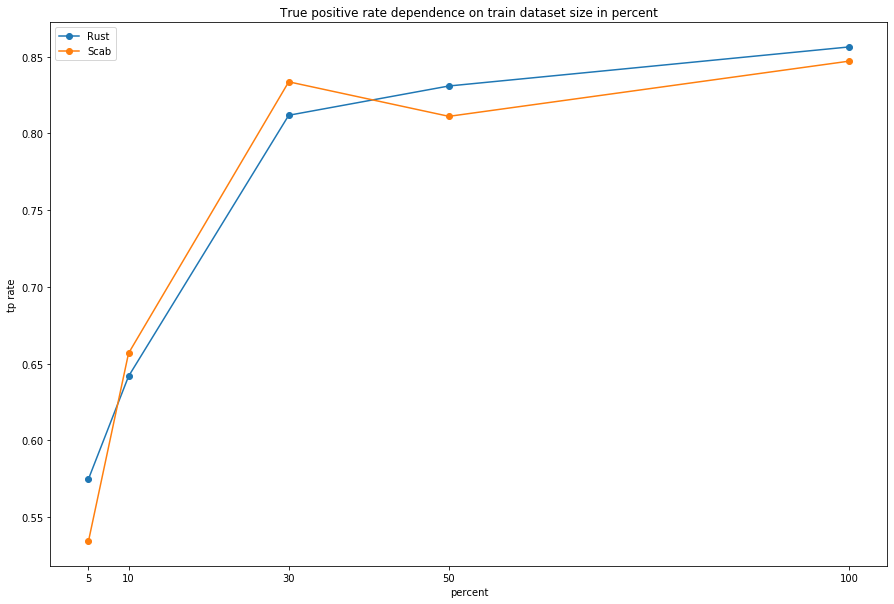

In [406]:
plt.figure(figsize=(15,10))
plt.plot(pr,tp_rust,marker='o', label='Rust')
plt.plot(pr,tp_scab, marker='o', label='Scab')
plt.xticks(pr)
plt.title('True positive rate dependence on train dataset size in percent')
plt.legend()
plt.xlabel('percent')
plt.ylabel('tp rate')
plt.show()

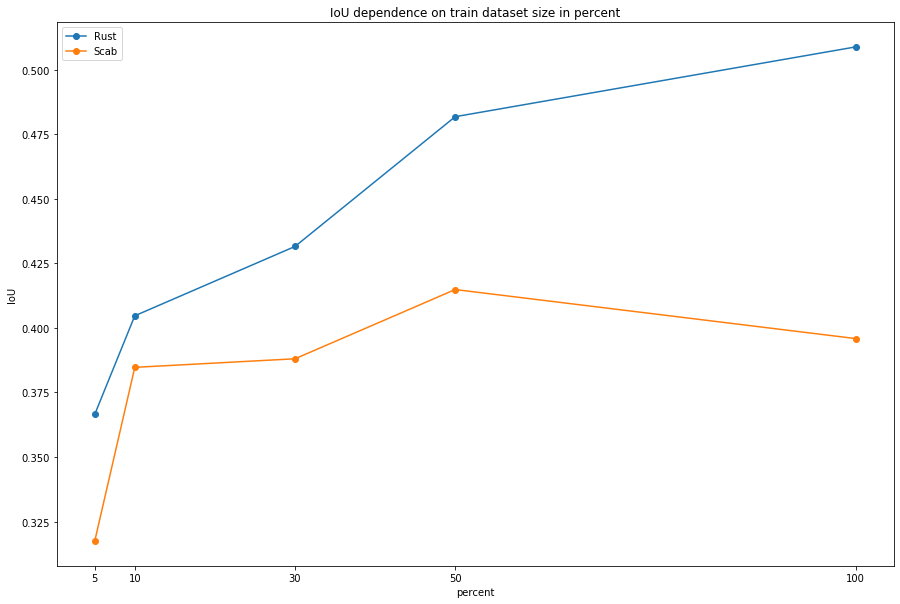

In [329]:
plt.figure(figsize=(15,10))
plt.plot(pr,rust,marker='o', label='Rust')
plt.plot(pr,scab, marker='o', label='Scab')
plt.xticks(pr)
plt.title('IoU dependence on train dataset size in percent')
plt.legend()
plt.xlabel('percent')
plt.ylabel('IoU')
plt.show()